<a href="https://colab.research.google.com/github/luyuzhe111/machine-learning-foundamentals/blob/main/GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pickle
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

In [2]:
with open('hw4_p3.pkl', 'rb') as f:
  data = pickle.load(f)

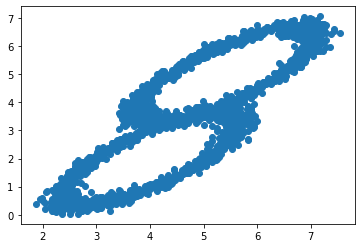

In [3]:
plt.scatter(data[:, 0], data[:, 1])

In [4]:
def create_mlp(architecture, activation):
  arch=[]
  act=nn.ReLU() if activation == 'relu' else nn.Identity()
  for i in range(1,len(architecture)-1):
    arch.append(nn.Linear(architecture[i-1], architecture[i]))            
    arch.append(act)
  arch.append(nn.Linear(architecture[-2], architecture[-1]))
  return nn.Sequential(*arch)

In [5]:
class Generator(nn.Module):
  def __init__(self, architecture=[2, 100, 100, 1], activation='relu'):
        super(Generator, self).__init__()      
        self.mlp = create_mlp(architecture, activation)
        
  def forward(self,inputs):            
        return self.mlp(inputs)

In [6]:
class Discriminator(nn.Module):
  def __init__(self, architecture=[2, 100, 100, 1], activation='relu'):
        super(Discriminator, self).__init__()      
        self.mlp = create_mlp(architecture, activation)
        self.sigmoid = nn.Sigmoid()
        
  def forward(self,inputs):            
        z=self.mlp(inputs)
        out=self.sigmoid(z)
        return out

In [7]:
neg_samples = torch.randn((2000, 2)).numpy()

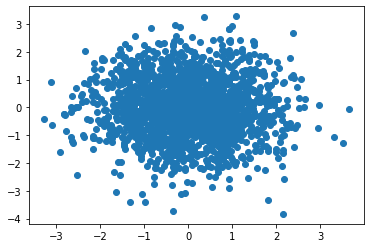

In [8]:
plt.scatter(neg_samples[:, 0], neg_samples[:, 1])

In [9]:
def positive_sampler(data_from_target_dist, batch_size):
  inds = torch.randint(len(data_from_target_dist), (batch_size, ))
  return data_from_target_dist[inds, :]

In [10]:
generator = Generator(architecture=[2, 100, 100, 2]).cuda()
discriminator = Discriminator(architecture=[2, 100, 100, 1]).cuda()

In [11]:
generator

Generator(
  (mlp): Sequential(
    (0): Linear(in_features=2, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=100, bias=True)
    (3): ReLU()
    (4): Linear(in_features=100, out_features=2, bias=True)
  )
)

In [12]:
discriminator

Discriminator(
  (mlp): Sequential(
    (0): Linear(in_features=2, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=100, bias=True)
    (3): ReLU()
    (4): Linear(in_features=100, out_features=1, bias=True)
  )
  (sigmoid): Sigmoid()
)

In [13]:
g_opt = optim.Adam(generator.parameters(), lr=1e-4)
d_opt = optim.Adam(discriminator.parameters(), lr=1e-4)

In [14]:
criterion = nn.BCELoss()

In [15]:
epochs = 6000
g_iters = 5
d_iters = 10
batch_size = 500

for epoch in range(epochs):
  for i in range(d_iters):
    d_opt.zero_grad()

    neg_samples = generator(torch.randn((batch_size, 2)).cuda())
    preds = discriminator(neg_samples)
    gts = torch.zeros((batch_size, 1)).cuda()
    neg_loss = criterion(preds, gts)

    pos_samples = positive_sampler(data, batch_size).cuda()
    preds = discriminator(pos_samples)
    gts = torch.ones((batch_size, 1)).cuda()
    pos_loss = criterion(preds, gts)

    loss = neg_loss + pos_loss
    loss.backward()
    d_opt.step()
  
  for j in range(g_iters):
    g_opt.zero_grad()
    g_samples = generator(torch.randn((batch_size, 2)).cuda())
    g_preds = discriminator(g_samples)
    g_loss = criterion(g_preds, torch.ones(batch_size, 1).cuda())
    g_loss.backward()
    g_opt.step()

In [16]:
neg_samples =torch.randn((2000, 2)).cuda()

In [17]:
g_samples = generator(neg_samples).detach().cpu().numpy()

In [18]:
g_samples.shape

(2000, 2)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Not providing a value for linspace's steps is deprecated and will throw a runtime error in a future release. This warning will appear only once per process. (Triggered internally at  ../aten/src/ATen/native/RangeFactories.cpp:23.)
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


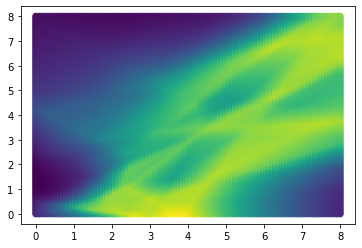

In [19]:
X,Y=torch.meshgrid(torch.linspace(0,8),torch.linspace(0,8))
xgrid=torch.stack([X.reshape(-1),Y.reshape(-1)],1)
discGrid=discriminator(xgrid.cuda())
discGrid=discGrid.detach().cpu().numpy()
plt.scatter(xgrid[:,0],xgrid[:,1],c=discGrid)

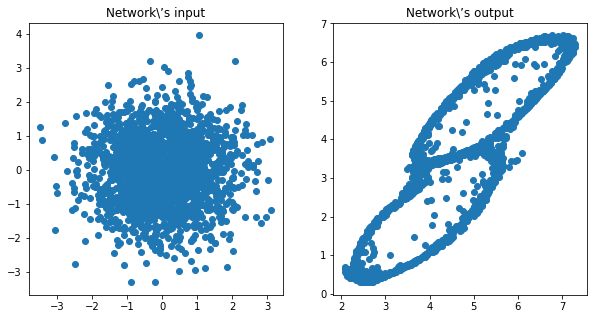

In [20]:
z=torch.randn((2000,2))
xhat=generator(z.cuda())
xhat=xhat.detach().cpu()
fig,ax=plt.subplots(1,2,figsize=(10,5))
ax[0].scatter(z[:,0],z[:,1])
ax[0].set_title('Network\’s input')
ax[1].scatter(xhat[:,0],xhat[:,1])
ax[1].set_title('Network\’s output')
plt.show()